In [2]:
using Causality, IntervalUnionArithmetic

# Generation of Epidemics

In [3]:
T, N = 50., 200
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,3/N)
G.A 

200×200 SparseArrays.SparseMatrixCSC{IndexedGraphs.NullNumber, Int64} with 1700 stored entries:
⠀⠀⠐⠀⢓⢐⠢⠄⠁⢂⠐⠐⢠⡀⠆⠰⣀⠠⢄⢁⡀⠠⡣⠆⢀⠐⠑⢄⠣⡀⢁⡠⠀⢀⣘⢈⠔⠈⢠⠀
⠐⠀⠐⡠⠈⠁⢢⠐⡀⠂⠑⢨⠈⠀⡈⠀⠀⢍⠙⡄⠈⠠⠂⠉⠃⠍⠑⠁⠀⠌⠐⠁⠉⠄⠐⠁⠀⡉⠈⢨
⢙⢐⠆⠀⢀⠐⡢⠀⠴⠁⠈⠀⠔⠠⠨⢔⣠⠀⠒⢠⡂⠄⡁⠁⠊⠈⡉⠂⠅⠊⢅⣓⠆⢔⡘⠍⠨⠉⠴⠅
⠈⠆⢈⠒⠈⠊⡀⢈⠐⣁⠩⠝⠒⡀⢀⠌⠈⠊⢂⢆⡣⠓⡁⢀⡁⠂⢉⡁⠄⣰⢎⢖⠉⠖⢨⠀⠠⠄⡂⠐
⠡⢀⠠⠈⠔⠃⠔⢠⠊⠀⠡⠀⠀⡐⢁⢂⠐⢈⠒⢀⡃⠃⢄⢔⠢⠠⠰⡈⠅⡢⠢⠔⠊⢖⢤⠢⡠⠄⣐⡄
⢐⠀⡑⣀⠂⠀⣇⠆⠁⠂⣤⡻⢹⠀⡁⠀⠈⣈⠑⡄⢗⠁⠂⡂⠃⡐⡕⡍⠆⠀⠀⡅⢈⡂⠰⠀⠰⠀⠀⢀
⠀⠲⠂⠀⠐⡁⠘⠠⢀⠠⠓⠒⢄⢑⠠⡈⡦⠂⠒⢠⠂⠐⠀⢣⠢⡒⠃⠧⡀⢨⠁⠇⡒⡰⠐⡀⠀⠢⡑⠁
⢈⡁⠂⠈⢂⢆⡀⠔⠡⢐⠁⠈⡀⠢⠀⠀⠀⠈⠀⠔⠉⠀⢀⡕⠀⠀⡢⠊⢄⠐⡀⢀⠎⠄⡀⢆⡠⠑⠖⠔
⠀⡘⡄⢄⠀⠚⡢⠀⡐⢀⡂⢠⠨⠋⡀⠀⢊⡰⠀⢜⣢⡂⠁⠐⠘⢭⠄⢘⢐⠀⠚⠃⢢⠝⠃⢂⠀⡄⡐⠠
⠄⢑⠓⠤⠘⣀⠨⢔⠘⢀⠑⠤⠘⣀⢀⠄⣀⢄⠊⠀⠃⠉⠆⢁⢃⠄⠄⢃⠄⢃⢀⡋⠃⢔⡰⢀⢰⢠⡐⠠
⠀⡈⠂⡀⠈⠌⢭⠊⠭⠈⠝⠑⢈⠀⠃⠀⠨⠺⡍⠀⡄⡩⠃⡂⠀⠐⠂⠘⠤⡕⠈⢫⠸⠊⠈⠀⠀⠂⠈⢀
⠩⠎⡌⠀⠅⠈⠁⢈⢀⢕⠨⠠⠤⣀⢄⠴⢁⠀⠌⢁⠩⠠⠀⠀⠀⠨⠭⡀⠅⢀⠉⠑⡤⠉⠉⢜⠪⢈⣀⢂
⢀⠐⡍⠄⡊⠀⠡⠈⠈⡂⢉⠠⢨⠢⠀⠀⡖⣄⠉⠔⢀⠀⡀⡀⠀⡤⣌⠑⡀⠐⠘⠃⣥⠞⠂⡐⢀⡔⠀⠢
⠑⢄⠕⠀⠣⠈⠇⠰⡐⠢⡕⠭⠭⡄⡨⠊⣀⢁⠤⢁⣈⠀⠃⠣⢆⠙⠄⠁⠂⠠⢐⡄⠏⢀⡘⢊⠐⣈⠠⠀
⠉⠢⡀⠄⡡⠁⢀⣡⠡⡡⠈⠁⡀⣈⢀⠑⠐⠐⠤⢁⢄⠧⠁⢁⢀⠈⠈⡀⠐⠀⡢⡠⠀⡠⠪⠁⠈⡠⠠⡀
⠁⡰⠔⠀⢥⢱⢪⢕⢈⠆⠄⠤⠥⠄⠀⢈⠾⠀⡤⠰⡦⣀⢇⠀⠶⠀⠐⠴⠈⡪⢤⠓⠅⠶⠶⠹⡁⠍⠩⠄
⠀⢀⠃⠄⢈⢅⢣⠄⢪⢄⠢⠰⢘⡨⠊⠅⣌⠖⢉⢄⡲⠂⡄⠋⣡⠟⠋⢁⠀⡠⢡⡅⡊⢈⣄⠅⠀⠎⢈⠠
⡒⢘⠔⠀⡖⠌⠂⠒⠠⡓⠐⠂⠐⠠⠠⢌⠩⢀⠐⢊⠂⠀⣃⢄⢈⠠⡲⢈⠎⠂⣜⡃⠄⠝⣀⠘⠠⢑⡰⡀
⡐⠁⡄⠠⡆⠂⠀⠆⠀⠎⠐⠂⠠⡀⢄⠊⠀⠤⠐⣒⠠⠀⡊⢂⢀⠴⡐⢠⠂⡠⡅⠌⡠⠄⢄⢂⠀⠀⠂⢇
⠀⠒⡂⣀⠔⠇⢈⠈⠐⠼⠀⢀⠕⠈⢘⠅⠐⡈⠐⡈⠂⢀⠠⢘⠠⡀⠀⠂⠀⠢⠃⠆⠂⡐⠐⠪⠬⢄⠄⠁

In [4]:
getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate, lat_gen::GaussianRate, rec_gen::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c lat_gen.a lat_gen.b lat_gen.c rec_gen.a rec_gen.b rec_gen.c]

getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate, latency::GaussianRate, recov::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
     fill(latency.a, 1, N); fill(latency.b, 1, N); fill(latency.c, 1, N);
     fill(recov.a, 1, N); fill(recov.b, 1, N); fill(recov.c, 1, N)
    ]

getparSI(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargenSI(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]



getpargenSI (generic function with 1 method)

In [5]:
#Initialize generation parameters
ε = 1e-10
λ = 0.5

pseed = 1/N 
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
latency = GaussianRate(1., T/2, 1/ε)
recov = GaussianRate(1., T/2, 1/ε)

inf_out = GaussianRate(λ, T/2, T)
l_delay = GaussianRate(0.27, 3., sqrt(3.56))
r_delay = GaussianRate(0.23, 16., sqrt(6.))

θp = getpar(pseed, autoinf, inf_in, latency, recov);
θpgen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

In [6]:
#Initialize min/max boundaies
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min, rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max, rate_max, rate_max);


rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max, rate_max, rate_max);

In [7]:
const Igauss = GaussianInferentialSEIR
const Igen = GenerativeSEIR{GaussianRate,GaussianRate,GaussianRate,GaussianRate} 

GenerativeSEIR{GaussianRate, GaussianRate, GaussianRate, GaussianRate}

In [22]:
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);

xtrue = zeros(N,3)
sample!(xtrue)
nobs, p = Int(round(N/4)), 1e-6
O = [(ti = T*(1+rand())/2; i =rand(1:N) ; (i,xtrue[i,1] < ti ,ti,p)) for r=1:nobs]
length([o for o in O if o[2]==1])

23

In [23]:
length([o for o in O if o[2]==0])

27

## Inference with Causality (SEIR)

In [26]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

θp2 = getpar(pseed, autoinf, inf_in, latency, recov);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

In [27]:
#Initialize the parameters to learn

autoinf = GaussianRate(1/N, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)
latency = GaussianRate(1., T/2, 2T)
recov = GaussianRate(1., T/2, 2T)


θ = getpar(pseed, autoinf, inf_in,  latency, recov);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [28]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2, O; M=M, numsamples=3000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
descend!(Mp2, O; M=M, numsamples=3000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.));

Progress: 100%|█████████████████████████████████████████| Time: 0:05:33
  F:  37.63167267259359


In [29]:
statscauSEIR = prior(M);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


## Inference with Causality (SIR)

In [31]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T/2)
l_delay = GaussianRate(100., 0.1, 10.)

θp2gen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

θp2 = getpar(pseed, autoinf, inf_in, latency, recov);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

In [32]:
#Initialize the parameters to learn

autoinf = GaussianRate(1/N, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)
latency = GaussianRate(1., T/2, 2T)
recov = GaussianRate(1., T/2, 2T)


θ = getpar(pseed, autoinf, inf_in,  latency, recov);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [33]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2, O; M=M, numsamples=3000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.1),hyper_mask=[1,2,3,4,8,9,10,11,12,13]);
descend!(Mp2, O; M=M, numsamples=3000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.02),hyper_mask=[1,2,3,4,8,9,10,11,12,13]);

Progress: 100%|█████████████████████████████████████████| Time: 0:08:25
  F:  46.57156473845221


In [34]:
statscauSIR = prior(M);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


## Inference with Causality (SI)

In [35]:
const IgenSI = GenerativeSI{GaussianRate,GaussianRate} 
const IgaussSI = GaussianInferentialSI
θmin = getparSI(pseed_min , rate_min, rate_min);
θmax = getparSI(pseed_max , rate_max, rate_max);


rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargenSI(pseed_min, rate_min, rate_min);
θgenmax = getpargenSI(pseed_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 2e-3

autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargenSI(pseed, autoinf, inf_out);

θp2 = getparSI(pseed, autoinf, inf_in);
Mp2 = StochasticModel(IgenSI, T, θp2, G, θp2gen);

In [36]:
#Initialize the parameters to learn

autoinf = GaussianRate(1/N, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)


θ = getparSI(pseed, autoinf, inf_in);
M = StochasticModel(IgaussSI, T, θ, G, θp2gen);

In [37]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2, O; M=M, numsamples=3000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.1),hyper_mask=[1,2,3,4]);
descend!(Mp2, O; M=M, numsamples=3000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.02),hyper_mask=[1,2,3,4]);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:06
  F:  35.80812821659245


In [38]:
statscauSI = prior(M);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


## Marginals and ROC curve

In [39]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i,1] .< t ) / numsamp
end

function marginalSI(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i] .< t ) / numsamp
end


function tpr(xtrue, rank) 
    den = sum(xtrue[rank])
    if den != 0
        return cumsum(xtrue[rank]) ./ den
    else
        return ones(size(rank))
    end
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [40]:
using Plots
p_cauSEIR = zeros(N,Int(T))
p_cauSIR = zeros(N,Int(T))
p_cauSI = zeros(N,Int(T))
for i = 1:N
    for t = 1:Int(T)
       p_cauSEIR[i,t] = marginal(i, t, statscauSEIR)
       p_cauSIR[i,t] = marginal(i, t, statscauSIR)
       p_cauSI[i,t] = marginalSI(i, t, statscauSI)
    end
end
i = 12
plot(p_cauSEIR[i,1:end], label = "cauSEIR")
plot!(p_cauSIR[i,1:end], label = "cauSIR")
plot!(p_cauSI[i,1:end], label = "cauSI")
savefig("marginals.pdf")

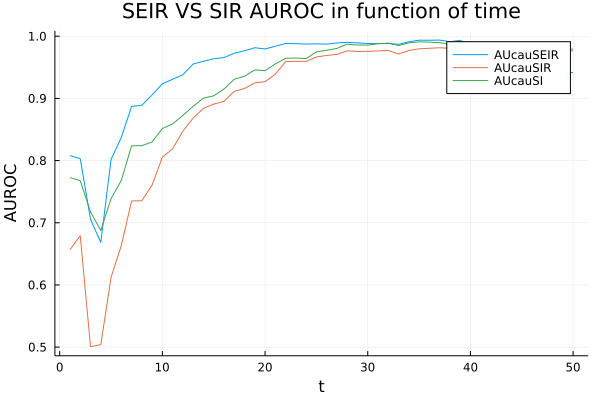

In [41]:
T = Int(T)
AU_cauSEIR=zeros(T)
AU_cauSIR=zeros(T)
AU_cauSI=zeros(T)
for t = 1:T
    cauSEIR_risk=zeros(N)
    cauSIR_risk=zeros(N)
    cauSI_risk=zeros(N)
    for i=1:N
       cauSEIR_risk[i] = marginal(i,t,statscauSEIR)
       cauSIR_risk[i] = marginal(i,t,statscauSIR)
       cauSI_risk[i] = marginalSI(i,t,statscauSI)
    end
    xt = xtrue[:,1] .< t-1e-3 
    AU_cauSEIR[t] = AUROC(ROC(xt, cauSEIR_risk))
    AU_cauSIR[t] = AUROC(ROC(xt, cauSIR_risk))
    AU_cauSI[t] = AUROC(ROC(xt, cauSI_risk))
end

plot(LinRange(1,T,T),AU_cauSEIR, label="AUcauSEIR", title="SEIR VS SIR AUROC in function of time")
plot!(LinRange(1,T,T),AU_cauSIR, label="AUcauSIR")
plot!(LinRange(1,T,T),AU_cauSI, label="AUcauSI")
T = Float64(T)
savefig("SierologicalAUROC")
xlabel!("t")
ylabel!("AUROC")